In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import copy
from tqdm import tqdm
import json
import pandas as pd
import time 
import datetime
from sklearn.model_selection import train_test_split

import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

torch.cuda.empty_cache()

from rouge import Rouge

### Hyperparameters

In [2]:
NUM_CHOICES = 4
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LR = 1e-5
TRAINING_BATCH_SIZE = 8
VAL_BATCH_SIZE = 1
EPOCHS = 7
NUM_WORKERS = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read dataset
The train.csv data is divided into a trainset (80 %) and test set (20 %)

In [3]:
loc = './dataset/'

cosmos_dataset = pd.read_csv(loc + 'train.csv')
train, test = train_test_split(cosmos_dataset, test_size=0.2, random_state=42, shuffle=True)
val = pd.read_csv(loc + 'valid.csv')

print('Train dataset size: {}'.format(len(train)))
print('Test dataset size: {}'.format(len(test)))
print('Dev dataset size: {}'.format(len(val)))

Train dataset size: 20209
Test dataset size: 5053
Dev dataset size: 2985


**Define collate function for dataloader**

Need to define how to stack batches since different sentences can have different lengths

In [4]:
def send_to_device(*args):
    return (item.to(DEVICE) 
            if isinstance(item, torch.Tensor) 
            else item
            for item in args)

In [5]:
def collate_fcn(batch):
    ids = [x['id'] for x in batch]
    features = [x['features'] for x in batch]
    tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, p_len_batch, q_len_batch, a_len_batch = ([] for _ in range(7))
    # read the batch of features
    for f_i in features:
        tokens, input_ids, input_masks, token_type_ids, p_len, q_len, a_len = ([] for _ in range(7))
        # each feature item has 4 datapoints for the four options
        for f in f_i:
            tokens.append(f[0])
            input_ids.append(f[1])
            input_masks.append(f[2])
            token_type_ids.append(f[3])
            p_len.append(f[4])
            q_len.append(f[5])
            a_len.append(f[6])
        tokens_batch.append(tokens)
        input_ids_batch.append(input_ids)
        input_masks_batch.append(input_masks)
        token_type_ids_batch.append(token_type_ids)
        p_len_batch.append(p_len)
        q_len_batch.append(q_len)
        a_len_batch.append(a_len)
    input_ids_batch = torch.tensor(input_ids_batch, dtype=torch.long)
    input_masks_batch = torch.tensor(input_masks_batch, dtype=torch.long)
    token_type_ids_batch = torch.tensor(token_type_ids_batch, dtype=torch.long)
    p_len_batch = torch.tensor(p_len_batch, dtype=torch.long)
    q_len_batch = torch.tensor(q_len_batch, dtype=torch.long)
    a_len_batch = torch.tensor(a_len_batch, dtype=torch.long)
    labels = torch.tensor([x['label'] for x in batch], dtype=torch.long)

    return ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, p_len_batch, q_len_batch, a_len_batch, labels

### Create Dataset

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, add_CLS=True):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.add_CLS = add_CLS

    def __len__(self):
        return len(self.df)

    def _truncate_seq(self, seq_1, seq_2, max_length):
        ''' Truncate a sequence pair in place to keep the combined length = maximum length. 
            Always truncate the longer sequence. '''
        while True:
            total_len = len(seq_1) + len(seq_2)
            if total_len <= max_length:
                break
            if len(seq_1) > len(seq_2):
                seq_1.pop()
            else:
                seq_2.pop()

    def __getitem__(self, index):
        row = self.df.iloc[index]
        id = row['id']
        context = row['context']
        question = row['question']
        options = [row['answer0'], row['answer1'], row['answer2'], row['answer3']]
        correct_opt = row['label']
        
        # take care of the case where the option is None
        options = [str(opt) if not isinstance(opt, str) else opt for opt in options]

        feature_set = []
        context_tokens = self.tokenizer.tokenize(context)
        question_tokens = self.tokenizer.tokenize(question)
        for opt in options:
            context_tokens_copy = copy(context_tokens)

            opt_tokens = self.tokenizer.tokenize(opt)
            q_opt_tok = question_tokens + opt_tokens

            # truncate the context and question + option if they are too long
            self._truncate_seq(context_tokens_copy, q_opt_tok, self.max_len - 3)

            ''' [CLS] context [SEP] question option [SEP] '''
            ''' [ 0      0      0      1       1      1 ] '''
            tokens = ['[CLS]'] + context_tokens_copy + ['[SEP]'] + q_opt_tok + ['[SEP]']
            token_type_ids = [0] * (len(context_tokens_copy) + 2) + [1] * (len(q_opt_tok) + 1)
            
            input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            input_masks = [1] * len(input_ids)

            # pad the tokens to max length
            padding_length = self.max_len - len(input_ids)
            padding = [0] * padding_length
            input_ids += padding
            input_masks += padding
            token_type_ids += padding

            assert len(input_ids) == self.max_len, "Input ids should be {}, but is {} instead".format(self.max_len, len(input_ids))
            assert len(input_masks) == self.max_len, "Input masks should be {}, but is {} instead".format(self.max_len, len(input_masks))
            assert len(token_type_ids) == self.max_len, "Token type ids should be {}, but is {} instead".format(self.max_len, len(token_type_ids))

            feature_set.append((tokens, input_ids, input_masks, token_type_ids,
                                len(context_tokens_copy), len(question_tokens), len(opt_tokens)))

        return {'id': id,
                'features': feature_set,
                'label': correct_opt}

## Model architecture for Question-Answering
To enhance the context understanding ability of BERT fine-tuning, we perform multiway bidirectional attention over the BERT encoding output. The model architecture is adopted from **DCMN+: Dual Co-Matching Network for Multi-choice Reading Comprehension** [(arxiv)](https://arxiv.org/pdf/1908.11511.pdf) 

In [7]:
class Single_matchNet(nn.Module):
    def __init__(self, config):
        super(Single_matchNet, self).__init__()
        self.trans_linear = nn.Linear(config.hidden_size, config.hidden_size)

    def forward(self, p_proj, q_proj, p_att, q_att):
        p_trans = self.trans_linear(p_proj)
        q_trans = self.trans_linear(q_proj)
        p2q_score = torch.matmul(p_trans, q_trans.transpose(2, 1))

        merged_p2q_att = p_att.unsqueeze(2).float().matmul(q_att.unsqueeze(1).float())
        merged_p2q_att = merged_p2q_att.to(dtype=next(self.parameters()).dtype)
        merged_p2q_att = (1.0 - merged_p2q_att) * -10000.0

        p2q_score_ = p2q_score + merged_p2q_att
        # normalize the attention scores to probabilities
        p2q_w = nn.Softmax(dim=-1)(p2q_score_)
        p2q_w_ = nn.Softmax(dim=1)(p2q_score_)

        # question attentive passage representation
        mp = torch.matmul(p2q_w, q_proj)
        # passage attentive question representation
        mq = torch.matmul(p2q_w_.transpose(2, 1), p_proj)

        return mp, mq
        
class Fuse_net(nn.Module):
    def __init__(self, config):
        super(Fuse_net, self).__init__()
        self.linear1 = nn.Linear(2 * config.hidden_size, config.hidden_size)
        self.linear2 = nn.Linear(2 * config.hidden_size, config.hidden_size)
        self.linear3 = nn.Linear(2 * config.hidden_size, config.hidden_size)

    def forward(self, p_seq, mp_q, mp_a, mp_qa, q_seq, mq_p, mq_a, mq_pa, a_seq, ma_p, ma_q, ma_pq):
        new_mp_q = torch.cat([mp_q - p_seq, mp_q * p_seq], dim=2)
        new_mp_a = torch.cat([mp_a - p_seq, mp_a * p_seq], dim=2)
        new_mp_qa = torch.cat([mp_qa - p_seq, mp_qa * p_seq], dim=2)
        new_mq_p = torch.cat([mq_p - q_seq, mq_p * q_seq], dim=2)
        new_mq_a = torch.cat([mq_a - q_seq, mq_a * q_seq], 2)
        new_mq_pa = torch.cat([mq_pa - q_seq, mq_pa * q_seq], 2)
        new_ma_p = torch.cat([ma_p - a_seq, ma_p * a_seq], 2)
        new_ma_q = torch.cat([ma_q - a_seq, ma_q * a_seq], 2)
        new_ma_pq = torch.cat([ma_pq - a_seq, ma_pq * a_seq], 2)

        new_mp = torch.cat([new_mp_q, new_mp_a, new_mp_qa], dim=1)
        new_mq = torch.cat([new_mq_p, new_mq_a, new_mq_pa], dim=1)
        new_ma = torch.cat([new_ma_p, new_ma_q, new_ma_pq], dim=1)

        new_mp_ = nn.functional.relu(self.linear1(new_mp))
        new_mq_ = nn.functional.relu(self.linear2(new_mq))
        new_ma_ = nn.functional.relu(self.linear3(new_ma))

        new_p_max, new_p_idx = torch.max(new_mp_, dim=1)
        new_q_max, new_q_idx = torch.max(new_mq_, dim=1)
        new_a_max, new_a_idx = torch.max(new_ma_, dim=1)

        new_p_max_ = new_p_max.view(-1, NUM_CHOICES, new_p_max.size(1))
        new_q_max_ = new_q_max.view(-1, NUM_CHOICES, new_q_max.size(1))
        new_a_max_ = new_a_max.view(-1, NUM_CHOICES, new_a_max.size(1))

        c = torch.cat([new_p_max_, new_q_max_, new_a_max_], dim=2)
        return c

In [8]:
def separate_seq(sequence_output, p_len, q_len, a_len):
    p_seq_output = sequence_output.new(sequence_output.size()).zero_()
    q_seq_output = sequence_output.new(sequence_output.size()).zero_()
    a_seq_output = sequence_output.new(sequence_output.size()).zero_()
    p_q_seq_output = sequence_output.new(sequence_output.size()).zero_()
    q_a_seq_output = sequence_output.new(sequence_output.size()).zero_()
    p_a_seq_output = sequence_output.new(sequence_output.size()).zero_()
    for i in range(p_len.size(0)):
        p_seq_output[i, :p_len[i]] = sequence_output[i, 1:p_len[i] + 1]
        q_seq_output[i, :q_len[i]] = sequence_output[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]
        a_seq_output[i, :a_len[i]] = sequence_output[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]

        p_q_seq_output[i, :p_len[i]] = sequence_output[i, 1:p_len[i] + 1]
        p_q_seq_output[i, p_len[i]:p_len[i] + q_len[i]] = sequence_output[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]

        q_a_seq_output[i, :q_len[i]] = sequence_output[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]
        q_a_seq_output[i, q_len[i]:q_len[i] + a_len[i]] = sequence_output[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]

        p_a_seq_output[i, :p_len[i]] = sequence_output[i, 1:p_len[i] + 1]
        p_a_seq_output[i, p_len[i]:p_len[i] + a_len[i]] = sequence_output[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]
    
    return p_seq_output, q_seq_output, a_seq_output, p_q_seq_output, q_a_seq_output, p_a_seq_output

def separate_attmask(flat_att_mask, p_len, q_len, a_len):
    p_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    q_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    a_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    p_q_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    q_a_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    p_a_seq_output = flat_att_mask.new(flat_att_mask.size()).zero_()
    for i in range(p_len.size(0)):
        p_seq_output[i, :p_len[i]] = flat_att_mask[i, 1:p_len[i] + 1]
        q_seq_output[i, :q_len[i]] = flat_att_mask[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]
        a_seq_output[i, :a_len[i]] = flat_att_mask[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]

        p_q_seq_output[i, :p_len[i]] = flat_att_mask[i, 1:p_len[i] + 1]
        p_q_seq_output[i, p_len[i]:p_len[i] + q_len[i]] = flat_att_mask[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]

        q_a_seq_output[i, :q_len[i]] = flat_att_mask[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]
        q_a_seq_output[i, q_len[i]:q_len[i] + a_len[i]] = flat_att_mask[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]

        p_a_seq_output[i, :p_len[i]] = flat_att_mask[i, 1:p_len[i] + 1]
        p_a_seq_output[i, p_len[i]:p_len[i] + a_len[i]] = flat_att_mask[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]
    
    return p_seq_output, q_seq_output, a_seq_output, p_q_seq_output, q_a_seq_output, p_a_seq_output


In [9]:
class BERT_multChoice(nn.Module):
    def __init__(self, hidden_size=None):
        super(BERT_multChoice, self).__init__()

        self.bert_encoder = BertModel.from_pretrained(MODEL_NAME)
        if hidden_size is None:
            hidden_size = self.bert_encoder.config.hidden_size
        self.classifier = nn.Linear(hidden_size * 3, 1)
        self.ssmatch = Single_matchNet(self.bert_encoder.config)
        self.fuse = Fuse_net(self.bert_encoder.config)

        self.loss_fcn = nn.CrossEntropyLoss()

    def forward(self, input_ids, token_type_ids, attention_mask, p_len, q_len, a_len, labels):
        # flatten the inputs
        flat_input_ids = input_ids.view(-1, input_ids.shape[-1])
        flat_token_type_ids = token_type_ids.view(-1, token_type_ids.shape[-1])
        flat_attention_mask = attention_mask.view(-1, attention_mask.shape[-1])
        p_len = p_len.view(-1, p_len.shape[0] * p_len.shape[1]).squeeze()
        q_len = q_len.view(-1, q_len.shape[0] * q_len.shape[1]).squeeze()
        a_len = a_len.view(-1, a_len.shape[0] * a_len.shape[1]).squeeze()

        output = self.bert_encoder(input_ids=flat_input_ids, token_type_ids=flat_token_type_ids, 
                                   attention_mask=flat_attention_mask, return_dict=True,
                                   encoder_hidden_states=True)
        pooled_output = output["pooler_output"]
        sequence_output = output["last_hidden_state"]

        p_seq_output, q_seq_output, a_seq_output, p_q_seq_output, q_a_seq_output, p_a_seq_output = \
            separate_seq(sequence_output, p_len, q_len, a_len)

        p_att_mask, q_att_mask, a_att_mask, p_q_att_mask, q_a_att_mask, p_a_att_mask = \
            separate_attmask(flat_attention_mask, p_len, q_len, a_len)

        mp_q, mq_p = self.ssmatch(p_seq_output, q_seq_output, p_att_mask, q_att_mask)
        mq_a, ma_q = self.ssmatch(q_seq_output, a_seq_output, q_att_mask, a_att_mask)
        mp_a, ma_p = self.ssmatch(p_seq_output, a_seq_output, p_att_mask, a_att_mask)
        mp_qa, mqa_p = self.ssmatch(p_seq_output, q_a_seq_output, p_att_mask, q_a_att_mask)
        mq_pa, mpa_q = self.ssmatch(q_seq_output, p_a_seq_output, q_att_mask, p_a_att_mask)
        ma_pq, mpq_a = self.ssmatch(a_seq_output, p_q_seq_output, a_att_mask, p_q_att_mask)

        c = self.fuse(p_seq_output, mp_q, mp_a, mp_qa, q_seq_output, mq_p, mq_a, mq_pa, a_seq_output, ma_p, ma_q, ma_pq)

        c_ = c.view(-1, c.size(2))
        logits = self.classifier(c_)
        logits = logits.view(-1, NUM_CHOICES)

        logits_copy = logits.clone().detach().cpu().numpy()
        prediction = np.argmax(logits_copy, axis=1)

        loss = self.loss(logits, labels)
        return loss, prediction
    
    def loss(self, logits, label):
        return self.loss_fcn(logits, label)


**Define the training loop**

In [10]:
def trainer(model, optimizer, train_loader, val_loader, resume=False, model_exists=False):
    model.to(DEVICE)

    # tensorboard
    writer = SummaryWriter()

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    cont_epoch = 0

    if resume and model_exists:
        model_dir = 'save_data/model_checkpoint.pth'
        model_checkpoint = torch.load(model_dir)
        model.load_state_dict(model_checkpoint['model_state_dict'])
        optimizer.load_state_dict(model_checkpoint['optimizer_state_dict'])

        fname = os.path.join(f'./save_data/training_loss.json')
        with open(fname, 'r') as f:
            training_loss = json.load(f)
        fname = os.path.join(f'./save_data/training_accuracy.json')
        with open(fname, 'r') as f:
            training_accuracy = json.load(f)
        fname = os.path.join(f'./save_data/validation_loss.json')
        with open(fname, 'r') as f:
            validation_loss = json.load(f)
        fname = os.path.join(f'./save_data/validation_accuracy.json')
        with open(fname, 'r') as f:
            validation_accuracy = json.load(f)

        cont_epoch = validation_accuracy[-1][0] + 1

    for epoch in range(cont_epoch, cont_epoch + EPOCHS):
        correct_predictions = 0
        train_sample_count = 0

        ''' training '''
        model.train()
        tic = time.time()
        for i, batch in enumerate(tqdm(train_loader, desc='Training', ncols=100, leave=False)):
            ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, \
                p_len_batch, q_len_batch, a_len_batch, labels = send_to_device(*batch)

            loss, prediction = model(input_ids_batch, token_type_ids_batch, input_masks_batch, 
                                p_len_batch, q_len_batch, a_len_batch, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            labels = labels.cpu().numpy()
            correct_predictions += np.sum(prediction == labels)
            training_loss.append(loss.item())
            train_sample_count += len(input_ids_batch)

            # write to tensorboard
            writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Accuracy/train', np.sum(prediction == labels) / len(input_ids_batch), epoch * len(train_loader) + i)
        
        training_accuracy.append((epoch, correct_predictions / train_sample_count))

        ''' validation '''
        val_sample_count = 0
        correct_predictions = 0
        
        model.eval()
        for j, data in enumerate(tqdm(val_loader, desc='Validation', ncols=100, leave=False)):
            ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, \
                p_len_batch, q_len_batch, a_len_batch, labels = send_to_device(*data)

            loss, prediction = model(input_ids_batch, token_type_ids_batch, input_masks_batch, 
                                     p_len_batch, q_len_batch, a_len_batch, labels)
            
            validation_loss.append(loss.item())
            labels = labels.cpu().numpy()
            correct_predictions += np.sum(prediction == labels)
            val_sample_count += len(input_ids_batch)

            # write to tensorboard
            writer.add_scalar('Loss/val', loss.item(), epoch * len(val_loader) + j)
            writer.add_scalar('Accuracy/val', np.sum(prediction == labels) / len(input_ids_batch), epoch * len(val_loader) + j)

        validation_accuracy.append((epoch, correct_predictions / val_sample_count))    

        tqdm.write(f'Epoch: {epoch}, Training time: {datetime.timedelta(time.time() - tic)} s, Training loss: {np.mean(training_loss)},' \
                   f'Training accuracy: {np.mean(list(zip(*training_accuracy))[1])},' \
                   f' Validation loss: {np.mean(validation_loss)}, Validation accuracy: {np.mean(list(zip(*validation_accuracy))[1])}')

    # save the trained models
    model_checkpoint = dict()
    model_checkpoint['model_state_dict'] = model.state_dict()
    model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    model_checkpoint['training_loss'] = training_loss
    model_checkpoint['training_accuracy'] = training_accuracy
    model_checkpoint['validation_loss'] = validation_loss
    model_checkpoint['validation_accuracy'] = validation_accuracy
    torch.save(model_checkpoint, f'./save_data/model_checkpoint.pth')
    
    return training_loss, training_accuracy, validation_loss, validation_accuracy

# Main()

In [11]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [12]:
train_dataset = Dataset(train, tokenizer, MAX_LEN)
val_dataset = Dataset(val, tokenizer, MAX_LEN)
test_dataset = Dataset(test, tokenizer, MAX_LEN)

In [13]:
params_dataLoader = {'batch_size': TRAINING_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': NUM_WORKERS,
                     'collate_fn': collate_fcn}
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, **params_dataLoader)

params_dataLoader = {'batch_size': VAL_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': 0,
                     'collate_fn': collate_fcn}
val_dataset_loader = torch.utils.data.DataLoader(val_dataset, **params_dataLoader)

In [14]:
model = BERT_multChoice().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

## Train
##### Change the variable ```resume``` to True if you want to continue training.


Epoch: 0, Training time: 1840 days, 15:50:41.887665 s, Training loss: 1.1252257241578172,Training accuracy: 0.5090306299173636, Validation loss: 1.0994374118604926, Validation accuracy: 0.5403685092127303


Epoch: 1, Training time: 1842 days, 12:51:17.771759 s, Training loss: 0.9397447096735982,Training accuracy: 0.6096293730516107, Validation loss: 1.081996136399589, Validation accuracy: 0.5695142378559463


Epoch: 2, Training time: 1842 days, 9:01:05.505981 s, Training loss: 0.7674095490187848,Training accuracy: 0.6877628779256767, Validation loss: 1.1124431419997658, Validation accuracy: 0.5796761585706309


Epoch: 3, Training time: 1876 days, 15:56:53.047028 s, Training loss: 0.6289334303444237,Training accuracy: 0.7471423623138206, Validation loss: 1.1978915148925884, Validation accuracy: 0.5835845896147404


Epoch: 4, Training time: 1858 days, 5:38:47.927399 s, Training loss: 0.5290285577142809,Training accuracy: 0.7884407937057747, Validation loss: 1.3314714748720144, Validation accuracy: 0.5847906197654942


Epoch: 5, Training time: 1845 days, 19:05:13.549805 s, Training loss: 0.4557084281419259,Training accuracy: 0.8186534052484866, Validation loss: 1.4128264618887167, Validation accuracy: 0.5878838637632607


Epoch: 6, Training time: 1842 days, 16:55:05.566406 s, Training loss: 0.4004020216254109,Training accuracy: 0.8412093621653718, Validation loss: 1.5150659478040684, Validation accuracy: 0.5908590571907155


(0.0, 1.0)

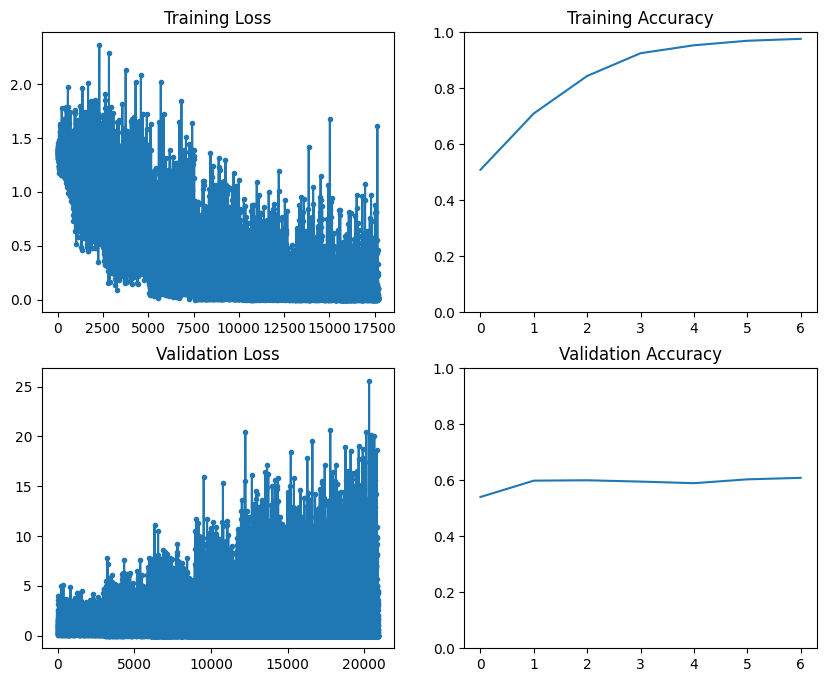

In [15]:
load = all([os.path.exists(f'save_data/{f}') for f in ['model_checkpoint.pth']])
resume = False

if resume:
    training_loss, training_accuracy, validation_loss, validation_accuracy = trainer(model, optimizer, train_dataset_loader, val_dataset_loader, resume, load)
elif load:
    fname = os.path.join(f'./save_data/model_checkpoint.pth')
    model_checkpoint = torch.load(fname)
    training_loss = model_checkpoint['training_loss']
    training_accuracy = model_checkpoint['training_accuracy']
    validation_loss = model_checkpoint['validation_loss']
    validation_accuracy = model_checkpoint['validation_accuracy']
else:
    os.makedirs('save_data', exist_ok=True)
    training_loss, training_accuracy, validation_loss, validation_accuracy = trainer(model, optimizer, train_dataset_loader, val_dataset_loader)

_, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(training_loss, marker='.')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(*zip(*training_accuracy))
ax[0, 1].set_title('Training Accuracy')
ax[1, 0].plot(validation_loss, marker='.')
ax[1, 0].set_title('Validation Loss')
ax[1, 1].plot(*zip(*validation_accuracy))
ax[1, 1].set_title('Validation Accuracy')

ax[0, 1].set_ylim([0, 1])
ax[1, 1].set_ylim([0, 1])

## Test

In [16]:
params_dataLoader = {'batch_size': 4,
                     'shuffle': False,
                     'num_workers': 0,
                     'collate_fn': collate_fcn}
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, **params_dataLoader)

In [17]:
def eval(model, test_loader):
    model.to(DEVICE)

    test_loss = []
    test_accuracy = []

    model_dir = 'save_data/model_checkpoint.pth'
    model_checkpoint = torch.load(model_dir)
    model.load_state_dict(model_checkpoint['model_state_dict'])

    correct_predictions = 0
    sample_count = 0

    ''' testing '''
    model.eval()
    for i, batch in enumerate(tqdm(test_loader, desc='Testing', ncols=100, leave=False)):
        ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, \
            p_len_batch, q_len_batch, a_len_batch, labels = send_to_device(*batch)

        loss, prediction = model(input_ids_batch, token_type_ids_batch, input_masks_batch, 
                                 p_len_batch, q_len_batch, a_len_batch, labels)

        labels = labels.cpu().numpy()
        correct_predictions += np.sum(prediction == labels)
        
        test_loss.append(loss.item())
        sample_count += len(input_ids_batch)

    print(sample_count)
    test_accuracy = correct_predictions / sample_count

    tqdm.write(f'Test loss: {np.mean(test_loss)}, Test accuracy: {test_accuracy}')

In [18]:
eval(model, test_dataset_loader)

5053
Test loss: 1.5937534674566278, Test accuracy: 0.6948347516326935


In [2]:
%%capture
import subprocess

subprocess.call('jupyter nbconvert hw3_906466769.ipynb --to pdf --output hw3_906466769_Output.pdf', shell=True)

[NbConvertApp] Converting notebook hw3_906466769.ipynb to pdf
[NbConvertApp] Support files will be in hw3_906466769_Output_files/
[NbConvertApp] Making directory ./hw3_906466769_Output_files
[NbConvertApp] Writing 104839 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 136979 bytes to hw3_906466769_Output.pdf
